# Exercise 5 - Thyroid desease prediction using Convolutional Neural Networks


Available at: 
- https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease
- http://networkrepository.com/thyroid-disease-thyroid0387.php

## 1. Importing libraries

In [1]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math
import itertools    

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

print("TF version:", tf.version)

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam

from tensorflow.python.client import device_lib
print("Is GPU backend?\n", device_lib.list_local_devices())


import matplotlib.pyplot as plt
from collections import Counter


2022-06-19 14:12:38.416410: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


TF version: <module 'tensorflow._api.v2.version' from '/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow/_api/v2/version/__init__.py'>
Is GPU backend?
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1504106200700601782
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 62586880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11406121349571818429
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


2022-06-19 14:12:39.606387: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-19 14:12:39.606975: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-19 14:12:39.632762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-19 14:12:39.653423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 14:12:39.653524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

## Downloading Training Dataset

The first step is the download of dataset and transform it into a pandas dataframe

In [2]:
print("Downloading the dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
print("Tranform to pandas dataframe")
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)


print("Shape:", dataTrain.shape)
print("Head")
dataTrain.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [3]:
# Removing NaN columns
del dataTrain[22]
del dataTrain[23]

In [4]:
# Visualizing the data
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [5]:
#Predictor data
inputTrain = dataTrain.drop([21], axis=1)
inputTrain.head()        

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153


In [6]:
# Target data
outputTrain = dataTrain[21] - 1

print("Labels", Counter(outputTrain))

Labels Counter({2: 3488, 1: 191, 0: 93})


In [7]:
#
# Downloading test data
#
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [8]:
del dataTest[22]
del dataTest[23]

In [9]:
inputTest = dataTest.drop([21], axis=1)
outputTest = dataTest[21] - 1

In [10]:
scaler = preprocessing.MinMaxScaler()
# fit using the train set
scaler.fit(inputTrain)
# transform the test test
xtrainN = scaler.transform(inputTrain)
xtestN = scaler.transform(inputTest) 

In [11]:
outputTrain_one_hot = keras.utils.to_categorical(outputTrain)

In [12]:
#
# Calculating class weights
#
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(outputTrain), y=outputTrain)
print("Labels:", np.unique(outputTrain))
print("Class weights:", class_weights)
d_class_weights = dict(enumerate(class_weights))

Labels: [0 1 2]
Class weights: [13.51971326  6.58289703  0.36047401]


In [13]:
 X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
     xtrainN, 
     outputTrain_one_hot, 
     test_size = 0.3, 
     random_state = 1, 
     stratify=outputTrain
 )  

In [14]:
model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 137,987
Trainable params: 137,987
Non-trainable params: 0
__________________________________________________

2022-06-19 14:13:48.500903: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-19 14:13:48.501104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 14:13:48.501279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.392GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2022-06-19 14:13:48.501345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-19 14:13:48.501379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-19 14:13:48.501403: I tensorflow/stream_executor/platfo

2022-06-19 14:13:55.557292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-19 14:13:55.577345: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


Epoch 1/500
 1/14 [=>............................] - ETA: 14s - loss: 0.7076 - fn: 158.0000 - fp: 126.0000 - tn: 274.0000 - tp: 42.0000 - precision: 0.2500 - recall: 0.2100

2022-06-19 14:13:56.530805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


14/14 [==============================] - 2s 52ms/step - loss: 0.6471 - fn: 1515.2000 - fp: 147.4000 - tn: 2983.2667 - tp: 50.1333 - precision: 0.2537 - recall: 0.0530 - val_loss: 0.5656 - val_fn: 1132.0000 - val_fp: 0.0000e+00 - val_tn: 2264.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
14/14 [==============================] - 0s 7ms/step - loss: 0.5963 - fn: 1545.6667 - fp: 0.2000 - tn: 3130.4667 - tp: 19.6667 - precision: 0.5969 - recall: 0.0081 - val_loss: 0.5283 - val_fn: 1017.0000 - val_fp: 2.0000 - val_tn: 2262.0000 - val_tp: 115.0000 - val_precision: 0.9829 - val_recall: 0.1016
Epoch 3/500
14/14 [==============================] - 0s 7ms/step - loss: 0.5561 - fn: 1152.9333 - fp: 16.7333 - tn: 3113.9333 - tp: 412.4000 - precision: 0.9666 - recall: 0.2362 - val_loss: 0.4492 - val_fn: 579.0000 - val_fp: 64.0000 - val_tn: 2200.0000 - val_tp: 553.0000 - val_precision: 0.8963 - val_recall: 0.4885
Epoch 4/500
14/14 [==========================

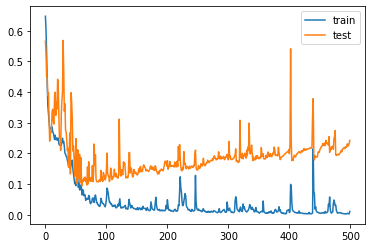

In [15]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("checkpoints/thyroid_model_at_epoch_{epoch}.h5")]

history = model.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs=500,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    class_weight=d_class_weights,
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


In [16]:
TrainPredictions = model.predict(inputTrain)
TrainPredictions = np.argmax(TrainPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

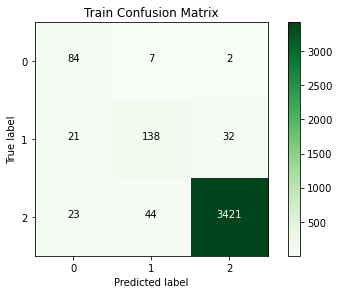

In [17]:
conf = confusion_matrix(outputTrain, TrainPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [18]:
print('Confusion Matrix\n')
print(conf)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTrain, TrainPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTrain, TrainPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTrain, TrainPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  84    7    2]
 [  21  138   32]
 [  23   44 3421]]

Accuracy: 0.97

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.79
Macro Recall: 0.87
Macro F1-score: 0.82

Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97

Classification Report

              precision    recall  f1-score   support

     Class 1       0.66      0.90      0.76        93
     Class 2       0.73      0.72      0.73       191
     Class 3       0.99      0.98      0.99      3488

    accuracy                           0.97      3772
   macro avg       0.79      0.87      0.82      3772
weighted avg       0.97      0.97      0.97      3772



In [19]:
TestPredictions = model.predict(inputTest)
TestPredictions = np.argmax(TestPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

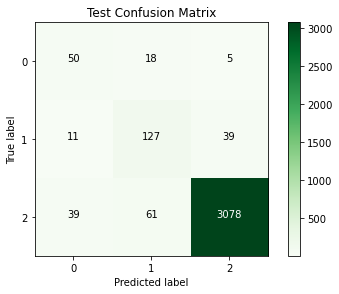

In [20]:
conf = confusion_matrix(outputTest, TestPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Test Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
print('Confusion Matrix\n')
print(conf)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTest, TestPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTest, TestPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTest, TestPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  50   18    5]
 [  11  127   39]
 [  39   61 3078]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.70
Macro Recall: 0.79
Macro F1-score: 0.74

Weighted Precision: 0.96
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

              precision    recall  f1-score   support

     Class 1       0.50      0.68      0.58        73
     Class 2       0.62      0.72      0.66       177
     Class 3       0.99      0.97      0.98      3178

    accuracy                           0.95      3428
   macro avg       0.70      0.79      0.74      3428
weighted avg       0.96      0.95      0.95      3428

